# Imports

In [2]:
import netsquid as ns
import numpy as np

import time

import os
from multiprocessing import get_context
from tqdm import tqdm
from dataclasses import dataclass, field

from enum import Enum, auto

import matplotlib.pyplot as plt

from adaptive_scape_tools import Basis, operators, kets, simulate_chunk

# Data models

In [3]:
@dataclass
class SimParams:
    fs: float # sampling rate
    delta_t: float # time between channel uses
    f: float #frequency of channel variation
    a: float # amplitude
    b: float # bias
    phi: float # phase
    N: int # estimation step
    M: int # number of simulations
    k_init: int # initial k value for all basis
    s_min: int # lower bound for CRI
    s_max: int # upper bound for CRI
    t_max: float # time window [sec]

    T_steps_sim: int # number of timestamps in a window
    remaining_T_steps: int

@dataclass
class EstimationStep:
    start_timestamp: int = 0
    k_x: int = field(init=False)                # repetition number for X basis
    k_y: int = field(init=False)                # repetition number for Y basis
    k_z: int = field(init=False)                # repetition number for Z basis
    channel_uses: int = field(init=False)
    
    message_length: int = field(init=False)
    message: np.ndarray = field(init=False)
    
    encoded_message_x: np.ndarray = field(init=False)
    encoded_message_y: np.ndarray = field(init=False)
    encoded_message_z: np.ndarray = field(init=False)

    gx: np.ndarray = field(init=False)
    gy: np.ndarray = field(init=False)
    gz: np.ndarray = field(init=False)

    p_true_x: np.ndarray = field(init=False)     # true Pauli parameters for samples in X basis
    p_true_y: np.ndarray = field(init=False)     # true Pauli parameters for samples in Y basis
    p_true_z: np.ndarray = field(init=False)     # true Pauli parameters for samples in Z basis
    
    received_message_x: np.ndarray = field(init=False)
    received_message_y: np.ndarray = field(init=False)
    received_message_z: np.ndarray = field(init=False)
    
    decoded_message_x: np.ndarray = field(init=False)
    decoded_message_y: np.ndarray = field(init=False)
    decoded_message_z: np.ndarray = field(init=False)

    cri_x: np.ndarray = field(init=False)
    cri_y: np.ndarray = field(init=False)
    cri_z: np.ndarray = field(init=False)

    corrected_message_x: np.ndarray = field(init=False)
    corrected_message_y: np.ndarray = field(init=False)
    corrected_message_z: np.ndarray = field(init=False)

    epsilon: np.ndarray = field(init=False)
    
    p_hat: np.ndarray = field(init=False)      # estimated Pauli parameters


# Configuration

In [12]:
def set_sim_parameters():    
    SimParams.N = 1000
    SimParams.M = 50
    SimParams.a = 0.3
    SimParams.b = 0.7
    SimParams.fs = 10000
    SimParams.delta_t = 1 / SimParams.fs 
    SimParams.f = 1
    SimParams.phi = np.pi/2
    SimParams.t_max = 2
    SimParams.k_init = 13

    SimParams.s_min = 1
    SimParams.s_max = 3
    
    SimParams.T_steps_sim = SimParams.fs * SimParams.t_max
    SimParams.remaining_T_steps = SimParams.T_steps_sim

# Functions definition

## Message generation

In [4]:

def message_for_step(est_step):
    '''
    Calculates the amount channel uses for next step
    Calculates the message length
    Generates the message for transfer
    '''
    
    est_step.message_length = est_step.pairs * 3
    est_step.message = np.random.randint(0, 2, size=est_step.message_length, dtype=np.int8)

    return 1

## Encode and split the message

In [5]:
def encode_and_split(est_step):
    '''
    encodes the original message and splits it to 3 basis
    '''
    bit_event = np.dtype([("bit_val", np.int8), ("timestamp", np.float64)])
    
    est_step.encoded_message_x = np.empty(est_step.message_length//3 * est_step.k_x, dtype=bit_event)
    est_step.encoded_message_y = np.empty(est_step.message_length//3 * est_step.k_y, dtype=bit_event)
    est_step.encoded_message_z = np.empty(est_step.message_length//3 * est_step.k_z, dtype=bit_event)
    
    #encoded_message = np.empty(est_step.message_length // 3 * (est_step.k_x + est_step.k_y + est_step.k_z), dtype=est_step.message.dtype)
    running_index = 0
    for i in range(est_step.message_length // 3):
        for j in range(est_step.k_x):
            #encoded_message[running_index] = est_step.message[i*3]
            est_step.encoded_message_x[i*est_step.k_x + j] = est_step.message[i*3], est_step.start_timestamp + running_index
            running_index+=1
        
        for j in range(est_step.k_y):
            #encoded_message[running_index] = est_step.message[i*3 + 1]
            est_step.encoded_message_y[i*est_step.k_y + j] = est_step.message[i*3 + 1], est_step.start_timestamp + running_index
            running_index+=1
        
        for j in range(est_step.k_z):
            #encoded_message[running_index] = est_step.message[i*3 + 2]
            est_step.encoded_message_z[i*est_step.k_z + j] = est_step.message[i*3 + 2], est_step.start_timestamp + running_index
            running_index+=1


## Pauli channel

### set gamma array

In [10]:
def gamma_t(t):
    return SimParams.b + SimParams.a*np.sin(2*np.pi*SimParams.f*t + SimParams.phi)

def set_gamma_arrays(est_step):
    est_step.gx = gamma_t(est_step.encoded_message_x["timestamp"]*SimParams.delta_t)
    est_step.gy = gamma_t(est_step.encoded_message_y["timestamp"]*SimParams.delta_t)
    est_step.gz = gamma_t(est_step.encoded_message_z["timestamp"]*SimParams.delta_t)

### set pauli parameters

In [16]:
def _pauli_params_from_gamma(gamma: np.ndarray) -> np.ndarray:
    g = np.asarray(gamma, dtype=np.float64)
    one = np.ones_like(g)
    G = 0.25 * np.stack([
        np.stack([one, g, g**2, g**3], axis=-1),
        np.stack([g, one, g, g**2],    axis=-1),
        np.stack([g**2, g, one, g],    axis=-1),
        np.stack([g**3, g**2, g, one], axis=-1),
    ], axis=-2)  # shape (N,4,4)

    eigs = np.linalg.eigvalsh(G)        # shape (N,4), ascending
    pZ, pY, pX, pI = eigs[:, 0], eigs[:, 1], eigs[:, 2], eigs[:, 3]
    P = np.stack((pI, pX, pY, pZ), axis=1)  # (N,4): [pI,pX,pY,pZ]

    # numeric hygiene
    if np.any(P < -1e-7):
        raise ValueError("Pauli parameters contain negative values.")
    P = np.clip(P, 0.0, None)
    P /= P.sum(axis=1, keepdims=True)
    return P

def set_pauli_params(est_step):
    for basis in ("x", "y", "z"):
        gamma = getattr(est_step, f"g{basis}")
        setattr(est_step, f"p_true_{basis}", _pauli_params_from_gamma(gamma))

## transfer message

In [8]:
def _transfer_msg(msg, pauli_parameters, basis, nproc=None):
    assert len(msg) == len(pauli_parameters), "Lengths of message and pauli array must match"

    nproc = nproc or os.cpu_count()

    # split message and pauli_parameters together
    msg_chunks = np.array_split(msg, nproc)
    param_chunks = np.array_split(pauli_parameters, nproc)

    # filter out empty splits
    chunks = [(m.tolist(), p.tolist()) 
              for m, p in zip(msg_chunks, param_chunks) if m.size]

    with get_context("spawn").Pool(processes=nproc) as pool:
        parts = pool.starmap(
            simulate_chunk,
            [(m, p, basis) for m, p in chunks]
        )
    return np.asarray([b for part in parts for b in part])

def transfer_messages(est_step):
    est_step.received_message_x = _transfer_msg(est_step.encoded_message_x["bit_val"], est_step.p_true_x, Basis.X)
    est_step.received_message_y = _transfer_msg(est_step.encoded_message_y["bit_val"], est_step.p_true_y, Basis.Y)
    est_step.received_message_z = _transfer_msg(est_step.encoded_message_z["bit_val"], est_step.p_true_z, Basis.Z)

## Error correction and error estimation

### decode with error correction and compute cri

In [9]:
def _decode(received_message, k):
    a = np.asarray(received_message)
    assert a.size % k == 0
    blocks = a.reshape(-1, k)

    ones = np.count_nonzero(blocks, axis=1)
    majority = (ones > k - ones).astype(int)
    cri_arr = np.abs(k - 2*ones) - (k - 1)/2

    return majority, cri_arr

def decode(est_step):
    est_step.decoded_message_x, est_step.cri_x = _decode(est_step.received_message_x, est_step.k_x)
    est_step.decoded_message_y, est_step.cri_y = _decode(est_step.received_message_y, est_step.k_y)
    est_step.decoded_message_z, est_step.cri_z = _decode(est_step.received_message_z, est_step.k_z)


### Encode

In [10]:
def _encode(message, k):
    return np.repeat(np.asarray(message), k)

def encode(est_step):
    est_step.corrected_message_x = _encode(est_step.decoded_message_x, est_step.k_x)
    est_step.corrected_message_y = _encode(est_step.decoded_message_y, est_step.k_y)
    est_step.corrected_message_z = _encode(est_step.decoded_message_z, est_step.k_z)
    

### estimates the errors

In [11]:
def _estimate_bsc_error(received_message, corrected_message):
    assert received_message.shape == corrected_message.shape
    flips = np.count_nonzero(received_message != corrected_message)

    return flips / received_message.size

def estimate_errors(est_step):
    est_step.epsilon = np.array([_estimate_bsc_error(est_step.received_message_x, est_step.corrected_message_x),
                       _estimate_bsc_error(est_step.received_message_y, est_step.corrected_message_y),
                       _estimate_bsc_error(est_step.received_message_z, est_step.corrected_message_z), 1.])

## Estimate Pauli

In [12]:
def estimate_pauli(est_step):
    A_inverse = np.array(
        [[-0.5, -0.5, -0.5, 1], 
         [-0.5, 0.5, 0.5, 0], 
         [0.5, -0.5, 0.5, 0], 
         [0.5, 0.5, -0.5, 0]])

    est_step.p_hat = np.dot(A_inverse, est_step.epsilon)

## Update k

In [13]:
def cri_update(cri_arr):
    bigger = np.sum(cri_arr > SimParams.s_max)
    lower = np.sum(cri_arr < SimParams.s_min)
    if lower > 0:
        return 1
    elif bigger > 0.9 * len(cri_arr):
        return -1
    else:
        return 0
        

# Run estimation window

In [14]:
def run_estimation_step(k_x, k_y, k_z, start_timestamp):
    '''
        Single estimation window
    '''
    # initialize Estimation step
    est_step = EstimationStep()
    est_step.k_x = k_x
    est_step.k_y = k_y
    est_step.k_z = k_z
    est_step.start_timestamp = start_timestamp        


    est_step.pairs = int(SimParams.N / (est_step.k_x + est_step.k_y + est_step.k_z))

    est_step.channel_uses = est_step.pairs * (est_step.k_x + est_step.k_y + est_step.k_z)
    if est_step.channel_uses > SimParams.remaining_T_steps:
        return None
    else:
        SimParams.remaining_T_steps -= est_step.channel_uses

    # message generation
    #print('SimParams.T_steps_sim', SimParams.T_steps_sim)
    #print('SimParams.remaining_T_steps', SimParams.remaining_T_steps)
    if message_for_step(est_step) is None:
        return None
    
    #print('SimParams.remaining_T_steps', SimParams.remaining_T_steps)
    
    #print('est_step.channel_uses', est_step.channel_uses)
    #print('est_step.message_length', est_step.message_length)
    #print('est_step.message.shape', est_step.message.shape)
    
    
    # Encode the message and split for 3 basis
    encode_and_split(est_step)
    
    # calculate gamma for each timestamp
    set_gamma_arrays(est_step)
    
    # calculate pauli parameters for each timestamp
    set_pauli_params(est_step)

    transfer_start = time.time()
    # transfer the message
    transfer_messages(est_step)
    transfer_stop = time.time()
    print("transfer time:", transfer_stop - transfer_start)
    
    # encode-decode
    decode(est_step)
    encode(est_step)
    
    # estimate average error for whole estimation step
    estimate_errors(est_step)
    
    # estimate average pauli parameters for whole estimation step
    estimate_pauli(est_step)

    # count cri and update kx, ky, kz
    est_step.k_x += cri_update(est_step.cri_x)
    est_step.k_y += cri_update(est_step.cri_y)
    est_step.k_z += cri_update(est_step.cri_z)

    return (est_step.p_hat, k_x, k_y, k_z, start_timestamp + est_step.channel_uses)

# M Simulations

In [18]:
# set simulation parameters
set_sim_parameters()
sims = []
for i in range(SimParams.M):
    # SET THE SEED
    ns.set_random_state(42+i)
    
    SimParams.remaining_T_steps = SimParams.T_steps_sim
    k_x = k_y = k_z = SimParams.k_init
    start_timestamp = 0
    
    p_hats = []
    
    start_time = time.time()
    
    res = run_estimation_step(k_x, k_y, k_z, start_timestamp)
    while res:
        p_hats.append(res[0])
        res = run_estimation_step(*res[1:])
    
    stop_time = time.time()
    
    print('i, time:', i, ',', stop_time - start_time)

    sims.append(p_hats)

i, time: 0 , 64.10416746139526
i, time: 1 , 67.55327224731445
i, time: 2 , 68.71464419364929
i, time: 3 , 66.1602349281311
i, time: 4 , 66.08186674118042
i, time: 5 , 65.57085037231445
i, time: 6 , 66.46749210357666
i, time: 7 , 66.04507970809937
i, time: 8 , 66.31019163131714
i, time: 9 , 66.27384924888611
i, time: 10 , 66.18755078315735
i, time: 11 , 66.51410937309265
i, time: 12 , 66.26629304885864
i, time: 13 , 66.68085074424744
i, time: 14 , 66.26481223106384
i, time: 15 , 66.60658502578735
i, time: 16 , 66.33129930496216
i, time: 17 , 65.79855632781982
i, time: 18 , 66.52587604522705
i, time: 19 , 66.39026188850403
i, time: 20 , 66.6918613910675
i, time: 21 , 66.45929598808289
i, time: 22 , 66.49900078773499
i, time: 23 , 66.34701013565063
i, time: 24 , 68.07070326805115
i, time: 25 , 69.52054476737976
i, time: 26 , 67.25542545318604
i, time: 27 , 72.92214918136597
i, time: 28 , 75.57101225852966
i, time: 29 , 68.53298759460449
i, time: 30 , 69.07421445846558
i, time: 31 , 70.029

# Intermediate results

In [14]:
#np.savez("50_runs.npz", data=sims)
sims = np.load("50_runs.npz", allow_pickle=True)["data"]
set_sim_parameters()
p_i_s = np.zeros((20,))
p_x_s = np.zeros((20,))
p_y_s = np.zeros((20,))
p_z_s = np.zeros((20,))
for i in range(50):
    for j in range(20):
        p_i_s[j] = sims[i][j][0]
        p_x_s[j] = sims[i][j][1]
        p_y_s[j] = sims[i][j][2]
        p_z_s[j] = sims[i][j][3]
tss = np.arange(1000, 21000, 1000)

(20000,)
(20000,)
(20000, 4)


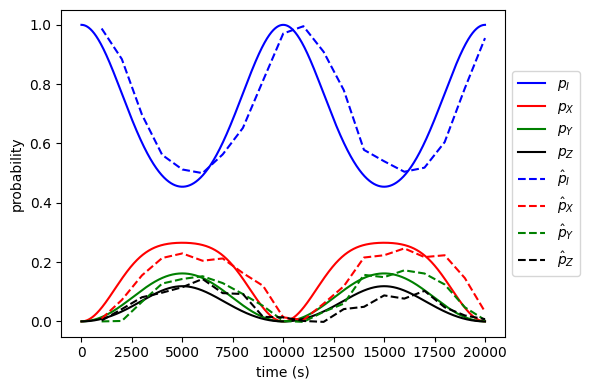

In [17]:
def draw_true_pauli(T=2.0, fS=1e4, a=0.3,b=0.7,f=100.0,phi=np.pi/2):
    n_samples = int(T * fS)
    t = np.arange(n_samples) / fS
    print(t.shape)

    gms = gamma_t(t)
    print(gms.shape)
    
    Ps = _pauli_params_from_gamma(gms)
    print(Ps.shape)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(Ps[:,0], color="blue", label=r"$p_I$")
    ax.plot(Ps[:,1], color="red",  label=r"$p_X$")
    ax.plot(Ps[:,2], color="green",label=r"$p_Y$")
    ax.plot(Ps[:,3], color="black",label=r"$p_Z$")

    ax.plot(tss, p_i_s, "b--", label=r"$\hat{p}_I$")
    ax.plot(tss, p_x_s, "r--", label=r"$\hat{p}_X$")
    ax.plot(tss, p_y_s, "g--", label=r"$\hat{p}_Y$")
    ax.plot(tss, p_z_s, "k--", label=r"$\hat{p}_Z$")
    
    ax.set_xlabel("time (s)")
    ax.set_ylabel("probability")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

draw_true_pauli()